In [1]:
import sys
import os
import random
import numpy as np
import matplotlib.pyplot as plt 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.python.client import device_lib 
from tqdm import tqdm

import cv2

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print(device_lib.list_local_devices())
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12729738723847198874
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10019143680
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4959846009131264052
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2023-10-23 10:45:50.327778: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 10:45:50.352268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-23 10:45:50.357135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-23 10:45:50.357266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

In [ ]:
# import requests
# import zipfile

# url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
# download_path = "./cats_and_dogs_filtered.zip"

# response = requests.get(url, stream=True)
# with open(download_path, "wb") as file:
#     for chunk in response.iter_content(chunk_size=128):
#         file.write(chunk)

# with zipfile.ZipFile(download_path, "r") as zip_ref:
#     zip_ref.extractall("./tmp")

In [2]:
train_dir = '/mnt/c/Users/Admin.IA/Desktop/scrap/chatarraEntrenamiento/train'
validation_dir = '/mnt/c/Users/Admin.IA/Desktop/scrap/chatarraEntrenamiento/val'
test_dir= r'/mnt/c/Users/Admin.IA/Desktop/scrap/chatarraEntrenamiento/test'

In [3]:
def calculate_mean_values(images):
    # Inicializa listas para los valores medios de cada canal de color
    mean_red = []
    mean_green = []
    mean_blue = []

    # Usa tqdm para agregar una barra de progreso
    for image in tqdm(images, desc="Calculating mean values:::"):
        mean_red.append(image[:, :, 0].mean())
        mean_green.append(image[:, :, 1].mean())
        mean_blue.append(image[:, :, 2].mean())

    # Calcula los valores medios finales
    mean_values = [np.mean(mean_red), np.mean(mean_green), np.mean(mean_blue)]

    return mean_values

def calculate_std_values(images):
    # Inicializa listas para las desviaciones estándar de cada canal de color
    std_red = []
    std_green = []
    std_blue = []

    # Usa tqdm para agregar una barra de progreso
    for image in tqdm(images, desc="Calculating standard deviation values"):
        std_red.append(image[:, :, 0].std())
        std_green.append(image[:, :, 1].std())
        std_blue.append(image[:, :, 2].std())

    # Calcula las desviaciones estándar finales
    std_values = [np.mean(std_red), np.mean(std_green), np.mean(std_blue)]

    return std_values
    
def load_and_preprocess_images(directory, target_size=(224, 224)):
    images = []
    labels = []
    class_names = os.listdir(directory)

    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)

        for filename in tqdm(os.listdir(class_dir), desc=f"Loading and preprocessing {class_name}"):
            if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
                image_path = os.path.join(class_dir, filename)
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Asegúrate de cargar la imagen en el formato correcto
                image = cv2.resize(image, target_size)  # Redimensiona la imagen al tamaño común
                images.append(image)
                labels.append(i)  # Etiqueta de clase correspondiente

    return np.array(images), np.array(labels)

# Cargar imágenes y etiquetas, redimensionando a un tamaño común (224x224)
images, labels = load_and_preprocess_images(train_dir, target_size=(224, 224))

# Ahora, 'images' contiene las imágenes redimensionadas y 'labels' contiene las etiquetas de clase correspondientes.
mean_values = calculate_mean_values(images)
std_values =  calculate_std_values(images)
print(mean_values)
print(std_values)

Loading and preprocessing CARRIL: 100%|████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.60it/s]
Loading and preprocessing CHATARRA_DE_ESCORIA_MINA_BOVEDA: 100%|███████████████████████| 40/40 [00:00<00:00, 154.57it/s]
Calculating standard deviation values: 100%|████████████████████████████████████████| 198/198 [00:00<00:00, 5135.79it/s]

[122.33815122284709, 120.33420511315322, 120.94382802837043]
[47.050560649258145, 46.043802593212675, 44.25448378815851]


In [7]:
num_classes = len(set(labels))

In [ ]:
# # define cnn model
# def define_model():
#     model = Sequential()
#     model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
#     model.add(Dense(2, activation='softmax'))
#     # compile model
#     opt = SGD(learning_rate=0.001, momentum=0.9)
#     model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#     return model
 
# # plot diagnostic learning curves
# def summarize_diagnostics(history):
#     # plot loss
#     plt.subplot(211)
#     plt.title('Cross Entropy Loss')
#     plt.plot(history.history['loss'], color='blue', label='train')
#     plt.plot(history.history['val_loss'], color='orange', label='test')
#     # plot accuracy
#     plt.subplot(212)
#     plt.title('Classification Accuracy')
#     plt.plot(history.history['accuracy'], color='blue', label='train')
#     plt.plot(history.history['val_accuracy'], color='orange', label='test')
#     # save plot to file
#     plt.show()
    
# # run the test harness for evaluating a model
# def run_test_harness():
#     # define model
#     model = define_model()
#     # create data generators
#     train_datagen = ImageDataGenerator(featurewise_center=True,
#     width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
#     train_datagen.mean = mean_values
#     test_datagen = ImageDataGenerator(featurewise_center=True)
#     test_datagen.mean = mean_values
#     # prepare iterators
#     train_it = train_datagen.flow_from_directory(train_dir,
#     class_mode='categorical', batch_size=64, target_size=(200, 200))
#     test_it = test_datagen.flow_from_directory(validation_dir,
#     class_mode='categorical', batch_size=64, target_size=(200, 200))
#     # fit model
#     history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
#     validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
#     # evaluate model
#     _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
#     print('> %.3f' % (acc * 100.0))
#     # learning curves
#     summarize_diagnostics(history)
#     # save model
#     model.save('my_model.keras')
    
#     return history, test_it, model
 
# # entry point, run the test harness
# training, test_data, model  = run_test_harness()

2023-10-23 10:48:44.677229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-23 10:48:44.677541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-23 10:48:44.677754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-23 10:48:44.678104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-23 10:48:44.678319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not op

Found 202 images belonging to 5 classes.
Found 29 images belonging to 5 classes.
Epoch 1/5


2023-10-23 10:48:46.535513: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2023-10-23 10:48:47.027084: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-23 10:48:55.111308: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4/4 - 16s - loss: 4.8042 - accuracy: 0.4950 - val_loss: 0.2699 - val_accuracy: 0.9655 - 16s/epoch - 4s/step
Epoch 2/5
4/4 - 1s - loss: 0.5754 - accuracy: 0.9505 - val_loss: 0.4560 - val_accuracy: 0.8966 - 1s/epoch - 332ms/step
Epoch 3/5
4/4 - 1s - loss: 0.1913 - accuracy: 0.9752 - val_loss: 0.1029 - val_accuracy: 0.9655 - 1s/epoch - 296ms/step
Epoch 4/5
4/4 - 1s - loss: 1.1435e-05 - accuracy: 1.0000 - val_loss: 4.1361e-04 - val_accuracy: 1.0000 - 1s/epoch - 299ms/step
Epoch 5/5
4/4 - 1s - loss: 4.2490e-08 - accuracy: 1.0000 - val_loss: 2.7992e-06 - val_accuracy: 1.0000 - 1s/epoch - 302ms/step
1/1 - 0s - loss: 2.7992e-06 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
> 100.000


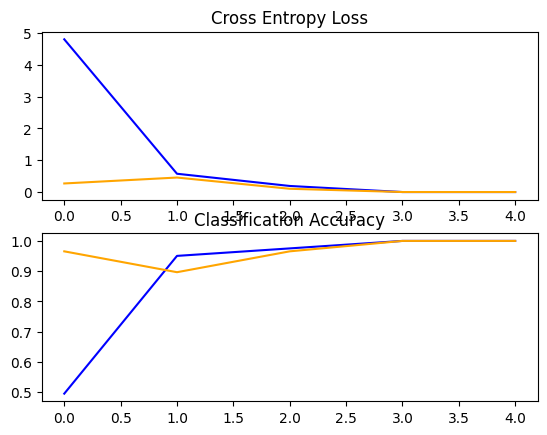

In [8]:
# define cnn model
def define_model():
    # load model
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(num_classes, activation='softmax')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
 
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    plt.show()
 
# run the test harness for evaluating a model
def run_test_harness():
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(featurewise_center=True)
    # datagen = ImageDataGenerator(rescale=1/255.0)
    # specify imagenet mean values for centering
    # datagen.mean = [123.68, 116.779, 103.939]
    datagen.mean = mean_values
    # prepare iterator
    train_it = datagen.flow_from_directory(train_dir,
                                           class_mode='categorical', batch_size=64, 
                                           target_size=(224, 224), shuffle=True)
    
    valid_it = datagen.flow_from_directory(validation_dir,
                                           class_mode='categorical', batch_size=64, 
                                           target_size=(224, 224))
    # fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it),
    validation_data=valid_it, validation_steps=len(valid_it), epochs=5, verbose=2)
    # evaluate model
    _, acc = model.evaluate(valid_it, steps=len(valid_it), verbose=2)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)
    # save model
    model.save('my_model.keras')
    
    return history, valid_it, model

# entry point, run the test harness
training, test_data, model = run_test_harness()

Found 65 images belonging to 5 classes.


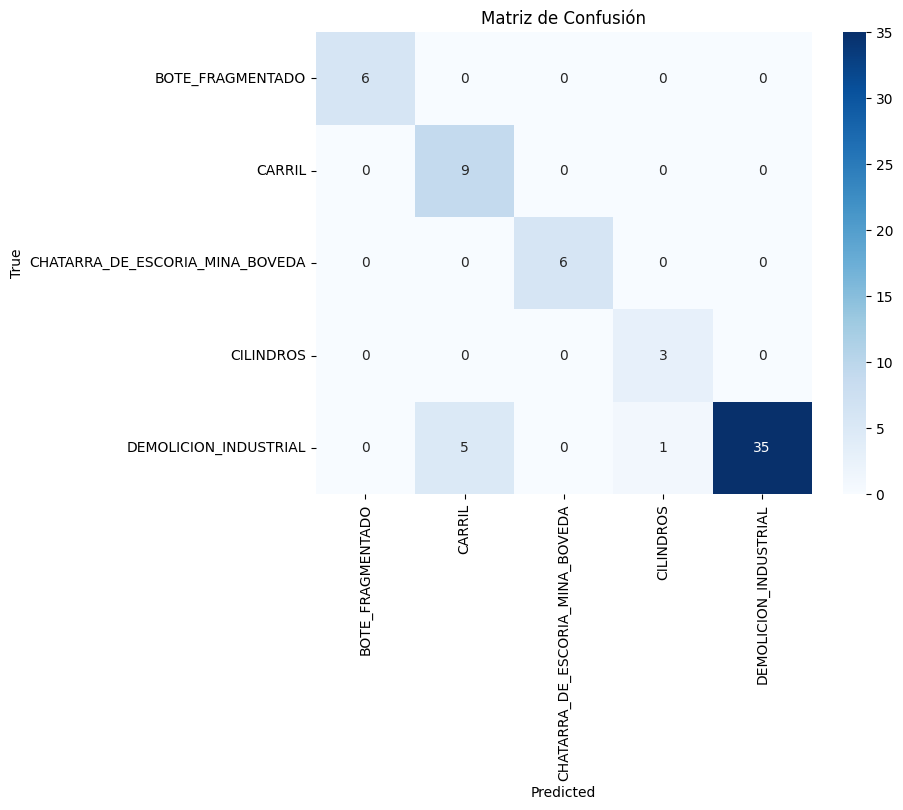

                                 precision    recall  f1-score   support

               BOTE_FRAGMENTADO       1.00      1.00      1.00         6
                         CARRIL       0.64      1.00      0.78         9
CHATARRA_DE_ESCORIA_MINA_BOVEDA       1.00      1.00      1.00         6
                      CILINDROS       0.75      1.00      0.86         3
          DEMOLICION_INDUSTRIAL       1.00      0.85      0.92        41

                       accuracy                           0.91        65
                      macro avg       0.88      0.97      0.91        65
                   weighted avg       0.94      0.91      0.91        65



In [9]:
datagen = ImageDataGenerator(featurewise_center=True)
datagen.mean = mean_values
valid_it = datagen.flow_from_directory(test_dir,
                                       class_mode='categorical', batch_size=64, 
                                       target_size=(224, 224),
                                       shuffle=False)

predictions = model.predict(valid_it)


y_true = valid_it.classes
y_pred = np.argmax(predictions, axis=1)
class_labels = list(valid_it.class_indices.keys())  
confusion = confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

In [10]:
# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(224, 224))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 224, 224, 3)
    # center pixel data
    img = img.astype('float32')
    img = img - mean_values
    return img

# load an image and predict the class
def run_example(file):
    # load the image
    img = load_image(file)
    # load model
    model = load_model('my_model.keras')
    # predict the class
    result = model.predict(img)
    predicted_class_index = np.argmax(result[0])
    print(result[0])
    print("Predicted class:", class_labels[predicted_class_index])
    plt.imshow(img[0]/ 255.0)
    plt.axis('off')  # Ocultar ejes
    plt.show()

In [31]:
BOTE_FRAGMENTADO = "/mnt/c/Users/Admin.IA/Desktop/scrap/chatarraEntrenamiento/test/BOTE_FRAGMENTADO/"
BOTE_FRAGMENTADO_list = os.listdir(BOTE_FRAGMENTADO)
CARRIL = "/mnt/c/Users/Admin.IA/Desktop/scrap/chatarraEntrenamiento/test/CARRIL/"
CARRIL_list = os.listdir(CARRIL)
CHATARRA_DE_ESCORIA_MINA_BOVEDA = "/mnt/c/Users/Admin.IA/Desktop/scrap/chatarraEntrenamiento/test/CHATARRA_DE_ESCORIA_MINA_BOVEDA/"
CHATARRA_DE_ESCORIA_MINA_BOVEDA_list = os.listdir(CHATARRA_DE_ESCORIA_MINA_BOVEDA)
CILINDROS = "/mnt/c/Users/Admin.IA/Desktop/scrap/chatarraEntrenamiento/test/CILINDROS/"
CILINDROS_list = os.listdir(CILINDROS)
DEMOLICION_INDUSTRIAL = "/mnt/c/Users/Admin.IA/Desktop/scrap/chatarraEntrenamiento/test/DEMOLICION_INDUSTRIAL/"
DEMOLICION_INDUSTRIAL_list = os.listdir(DEMOLICION_INDUSTRIAL)

clase real:  CILINDROS


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 0. 1. 0.]
Predicted class: CILINDROS


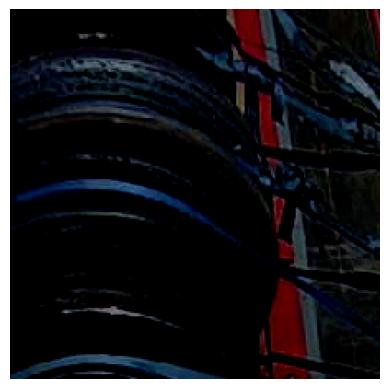

In [46]:
carpeta = random.choice([BOTE_FRAGMENTADO, CARRIL, CHATARRA_DE_ESCORIA_MINA_BOVEDA, CILINDROS, DEMOLICION_INDUSTRIAL])
i_target = random.choice(os.listdir(carpeta))

ruta_img = carpeta + i_target
print("clase real: ", carpeta.split("/")[-2])

run_example(ruta_img)